In [1]:
import pandas as pd
import glob
from bs4 import BeautifulSoup
import re
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud
import nltk
import time
import matplotlib.pyplot as plt
import pickle
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import f1_score, accuracy_score, hamming_loss, jaccard_score
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from skmultilearn.adapt import MLkNN
from skmultilearn.problem_transform import LabelPowerset, BinaryRelevance, ClassifierChain
from sklearn.linear_model import LogisticRegression
import spacy
from scipy.sparse import csr_matrix, lil_matrix
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn import pipeline
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.model_selection import GridSearchCV

In [2]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 1000)

In [4]:
path = 'Saves/Dataset_cleaned&shaped.pkl'
df = pd.read_pickle(path)

In [33]:
df = df.sample(n=10000, random_state=42)

In [5]:
df.head()

,Tags,Corpus,.net,ajax,algorithm,arrays,asp.net,asp.net-mvc,c,c#,c++,cocoa,cocoa-touch,css,database,debugging,delphi,django,eclipse,git,html,iphone,java,javascript,jquery,linq,linux,macos,multithreading,mysql,objective-c,performance,perl,php,python,regex,ruby,ruby-on-rails,security,sql,sql-server,string,svn,unit-testing,vb.net,visual-studio,visual-studio-2008,wcf,windows,winforms,wpf,xml
0,"[c#, c++, c]",purpose anonymous block c style language purpo...,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"[c#, wpf]",mef unable import class edit matt solve linger...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,[cocoa-touch],zoom uiimage object pinch screen zoom uiimage ...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,[objective-c],significance start constant teach objective c ...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,[regex],split prefix character regular expression spli...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [7]:
filename = 'Saves/multilabel_binarizer.pkl'
multilabel_binarizer = pickle.load(open(filename, 'rb'))

# 1. Constitution d'un jeu de données train & test

Il est à présent possible de couper en deux le dataset avec une partie servant d'apprentissage et l'autre au test du model. On utilise ici les variables Corpus et Tags pour les raisons définies précédemment.

In [36]:
train, test = sklearn.model_selection.train_test_split(df, test_size=0.33, random_state=42)
print("Length of train set : {}".format(len(train)))
print("Length of test set : {}".format(len(test)))

Length of train set : 6700
Length of test set : 3300


Il est maintenant possible de diviser chaque étape du dataset en 2 parties:

In [37]:
X_train, y_train = train.Corpus, train.drop(['Corpus', 'Tags'], axis=1)
X_test, y_test = test.Corpus, test.drop(['Corpus', 'Tags'], axis=1)

# 2. Représentation des données sous forme de sacs de mots (bag of words)

## 2.1. Création du Bag of Words

L'une des méthodes les plus simples, mais aussi les plus efficaces et les plus courantes, servant à transformer les textes afin de leur donner un format reconnaissable pour l'apprentissqge automatique, consiste à utiliser une représentation dites par sacs de mots (bag of words). Avec cette représentation, nous éliminons l'essentiel de la structure du texte présenté en entrée, comme les chapitres, les paragraphes, les phrases et tout ce qui concerne le formatage, et nous comptons uniquement le nombre d'apparitions de chaque mot dans chaque texte du corpus.

Calculer la représentation par sac de mots d'un corpus consiste à suivre une succession de trois étapes:
+ Tokenisation. Ce terme désigne le fait de partager un document dans les mots qui le composent, par exemple pour distinguer les espaces ou encore les signes de ponctuation. Un texte devient alors une séquence de tokens.
+ Construction du vocabulaire. Cela consiste à former un vocabulaire en collectant tous les mots qui apparaissent dans les documents afin de constituer un dictionnaire, et à les numéroter (par exemple dans l'ordre alphabétique).
+ Encodage. Pour chaque document, cette étape consiste à dénombrer le nombre d'occurence de chaque mot du vocabulaire.

Appliquons donc ces trois étapes sur notre jeu de données de stackoverflow.

In [38]:
print("X_train.shape : {}".format(X_train.shape))
print("X_test.shape : {}".format(X_test.shape))

X_train.shape : (6700,)
X_test.shape : (3300,)


In [39]:
custom_vectorizer = CountVectorizer(tokenizer=None, stop_words=None, min_df=5) 

In [40]:
custom_vectorizer.fit(X_train)
custom_vectorizer.fit(X_test)
X_train_BOW = custom_vectorizer.transform(X_train)
X_test_BOW = custom_vectorizer.transform(X_test)

In [41]:
filename = 'custom_vectorizer.pkl'
pickle.dump(custom_vectorizer, open(filename, 'wb'))

In [42]:
print("X_train_BOW.shape : {}".format(X_train_BOW.shape))
print("X_test_BOW.shape : {}".format(X_test_BOW.shape))

X_train_BOW.shape : (6700, 2329)
X_test_BOW.shape : (3300, 2329)


# Binary Relevance

In [81]:
br_classifier = BinaryRelevance(GaussianNB())
br_classifier.fit(X_train_BOW, y_train)
br_predictions = br_classifier.predict(X_test_BOW)

In [82]:
print("F1 score = {}".format(f1_score(y_test, br_predictions, average="samples")))
print("Jaccard score = {}".format(jaccard_score(y_test, br_predictions, average='samples')))
print("Hamming loss = {}".format(hamming_loss(y_test, br_predictions)))

F1 score = 0.18910864917373912
Jaccard score = 0.14142932913500664
Hamming loss = 0.08932121212121212


# K Neighbors

In [83]:
kn_classifier = KNeighborsClassifier()
kn_classifier.fit(X_train_BOW, y_train)
kn_predictions = kn_classifier.predict(X_test_BOW)

In [84]:
print("F1 score = {}".format(f1_score(y_test, kn_predictions, average="samples")))
print("Jaccard score = {}".format(jaccard_score(y_test, kn_predictions, average='samples')))
print("Hamming loss = {}".format(hamming_loss(y_test, kn_predictions)))

F1 score = 0.19243434343434343
Jaccard score = 0.17570707070707067
Hamming loss = 0.02756969696969697


# MLkNN

In [85]:
# to prevent errors when handling sparse matrices.
X_train_BOW_MLkNN = lil_matrix(X_train_BOW).toarray()
y_train_BOW_MLkNN = lil_matrix(y_train).toarray()
X_test_BOW_MLkNN = lil_matrix(X_test_BOW).toarray()

In [86]:
ml_classifier = MLkNN(k=10)
ml_classifier.fit(X_train_BOW_MLkNN, y_train_BOW_MLkNN)
ml_predictions = ml_classifier.predict(X_test_BOW_MLkNN)

C:\Users\germa\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_neighbors=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [87]:
print("F1 score = {}".format(f1_score(y_test, ml_predictions, average="samples")))
print("Jaccard score = {}".format(jaccard_score(y_test, ml_predictions, average='samples')))
print("Hamming loss = {}".format(hamming_loss(y_test, ml_predictions)))

F1 score = 0.2386060606060606
Jaccard score = 0.2146464646464646
Hamming loss = 0.02703030303030303


# Extra Trees

In [88]:
et_classifier = ExtraTreesClassifier(n_estimators=50)
et_classifier = et_classifier.fit(X_train_BOW, y_train)
et_predictions = et_classifier.predict(X_test_BOW)

In [89]:
print("F1 score = {}".format(f1_score(y_test, et_predictions, average="samples")))
print("Jaccard score = {}".format(jaccard_score(y_test, et_predictions, average='samples')))
print("Hamming loss = {}".format(hamming_loss(y_test, et_predictions)))

F1 score = 0.3472424242424243
Jaccard score = 0.3227777777777777
Hamming loss = 0.022006060606060605


# Random Forest

In [90]:
rf_classifier = RandomForestClassifier(n_estimators=50)
rf_classifier = rf_classifier.fit(X_train_BOW, y_train)
rf_predictions = rf_classifier.predict(X_test_BOW)

In [91]:
print("F1 score = {}".format(f1_score(y_test, rf_predictions, average="samples")))
print("Jaccard score = {}".format(jaccard_score(y_test, rf_predictions, average='samples')))
print("Hamming loss = {}".format(hamming_loss(y_test, rf_predictions)))

F1 score = 0.38699999999999996
Jaccard score = 0.35926767676767674
Hamming loss = 0.021757575757575757


# Label Powerset

In [92]:
lp_classifier = LabelPowerset(LogisticRegression())
lp_classifier.fit(X_train_BOW, y_train)
lp_predictions = lp_classifier.predict(X_test_BOW)

C:\Users\germa\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [93]:
print("F1 score = {}".format(f1_score(y_test, lp_predictions, average="samples")))
print("Jaccard score = {}".format(jaccard_score(y_test, lp_predictions, average='samples')))
print("Hamming loss = {}".format(hamming_loss(y_test, lp_predictions)))

F1 score = 0.5253910533910534
Jaccard score = 0.47862121212121206
Hamming loss = 0.02583030303030303


# Classifier Chain

In [94]:
#for the next classifier we need to remove from y-train, y-test categories which equal 0 for all train samples
selected_labels = y_train.columns[y_train.sum(axis=0, skipna=True) > 0].tolist()
y_train_CC = y_train.filter(selected_labels, axis=1)
y_test_CC = y_test.filter(selected_labels, axis=1)

cc_classifier = ClassifierChain(LogisticRegression())
cc_classifier.fit(X_train_BOW, y_train_CC)
cc_predictions_proba = cc_classifier.predict_proba(X_test_BOW)

C:\Users\germa\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\germa\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

In [95]:
#for plotting metrics as a function of threashold
th = []
f = []
jac = []
ham = []

for t in range (1,101): # threshold value
    y_pred_new = (cc_predictions_proba >= t/100).astype(int)
    th.append(t/100)
    f.append(f1_score(y_test_CC, y_pred_new, average="samples"))
    jac.append(jaccard_score(y_test_CC, y_pred_new, average='samples'))
    ham.append(hamming_loss(y_test_CC, y_pred_new))

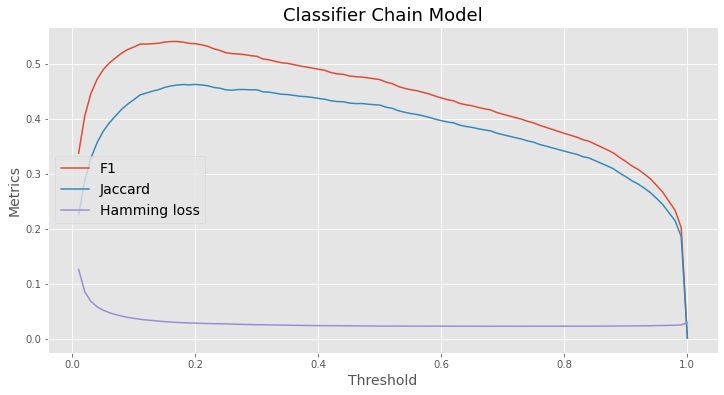

In [96]:
plt.rcParams["figure.figsize"] = (12, 6)

with plt.style.context('ggplot'):
    plt.plot(th, f)
    plt.plot(th, jac)
    plt.plot(th, ham)
    plt.legend(['F1', 'Jaccard', 'Hamming loss'], loc='center left', fontsize=14)
    plt.ylabel("Metrics", fontsize=14)
    plt.xlabel("Threshold", fontsize=14)
    plt.title("Classifier Chain Model", fontsize=18)

plt.show()

# Optimisation des meilleurs modèles supervisés

## Label Powerset

In [43]:
parameters = [
    {'classifier' : [LogisticRegression()],
     'classifier__penalty' : ['l1', 'l2'],
     'classifier__C' : np.logspace(-4, 4, 20),
     'classifier__solver' : ['liblinear']
    },
    {'classifier' : [RandomForestClassifier()],
     'classifier__n_estimators' : list(range(10,250,25)),
     'classifier__max_features' : list(range(5,40,5))
    }
]

scr = {'F1': 'f1_samples', 'Jaccard': 'jaccard_samples'}

clf = GridSearchCV(LabelPowerset(), parameters, scoring=scr, refit='F1', n_jobs=-1)
clf.fit(X_train_BOW, y_train)

print(clf.best_params_, clf.best_score_)

{'classifier': LogisticRegression(C=1.623776739188721, penalty='l1', solver='liblinear'), 'classifier__C': 1.623776739188721, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'} 0.5136004501303008


In [44]:
BEST_lp_classifier = LabelPowerset(RandomForestClassifier(max_features=26, n_estimators=100))
BEST_lp_classifier.fit(X_train_BOW, y_train)
BEST_lp_prediction = BEST_lp_classifier.predict(X_test_BOW)

In [45]:
print("F1 score = {}".format(f1_score(y_test, BEST_lp_prediction, average="samples")))
print("Jaccard score = {}".format(jaccard_score(y_test, BEST_lp_prediction, average='samples')))
print("Hamming loss = {}".format(hamming_loss(y_test, BEST_lp_prediction)))

F1 score = 0.5792395382395383
Jaccard score = 0.5311464646464646
Hamming loss = 0.02209090909090909


In [46]:
filename = 'Saves/lp_classifier.pkl'
pickle.dump(BEST_lp_classifier, open(filename, 'wb'))

In [48]:
lp_prediction_labels = multilabel_binarizer.inverse_transform(BEST_lp_prediction)

In [77]:
lp_prediction_labels

[('c#',),
 ('java',),
 ('asp.net',),
 ('c#',),
 ('jquery',),
 ('c#', 'linq'),
 ('php',),
 ('php',),
 ('c#',),
 ('wpf',),
 ('sql-server',),
 ('wpf',),
 ('css', 'html'),
 ('java',),
 ('python',),
 ('wpf',),
 ('c#', 'linq'),
 ('c#',),
 ('c#',),
 ('mysql',),
 ('python',),
 ('c#',),
 ('iphone',),
 ('c#',),
 ('html',),
 ('jquery',),
 ('java',),
 ('javascript',),
 ('c#', 'linq'),
 ('sql',),
 ('css', 'html'),
 ('c#',),
 ('c#',),
 ('jquery',),
 ('jquery',),
 ('c++',),
 ('mysql',),
 ('c#',),
 ('ruby',),
 ('c++',),
 ('.net', 'c#'),
 ('ruby-on-rails',),
 ('ruby',),
 ('c#',),
 ('svn',),
 ('wpf',),
 ('php',),
 ('delphi',),
 ('php',),
 ('c#',),
 ('java',),
 ('c#',),
 ('mysql',),
 ('java',),
 ('php',),
 ('c#',),
 ('c#',),
 ('jquery',),
 ('delphi',),
 ('linux',),
 ('sql',),
 ('asp.net-mvc',),
 ('javascript',),
 ('jquery',),
 ('java',),
 ('c#',),
 ('php',),
 ('.net',),
 ('asp.net',),
 ('java',),
 ('sql',),
 ('wpf',),
 ('sql',),
 ('php',),
 ('python',),
 ('php',),
 ('python',),
 ('php',),
 ('xml',),
 ('c

In [78]:
list(X_test)

['c reflection problemi following reflection following statement evaluate false evaluate true idea',
 'monitor wait pulse race condition multithreaded serveri interlock monitor wait monitor pulse multi threaded tcp demonstrate issue client client send seven message print press return test press return terminate echo handler test echo handler test echo handler test echo handler test suspect monitor getting confuse allow occur method occur method lock object method acquire lock send comment line method remain message appear method wake object cause dispatch remain incoming message occur race condition method lock object prevent idea simon ps note aware output appear order specifically ask race condition lock monitor cheers sh',
 'handle control event contain pagei control contain save button click event attach save button handle contain page control possible edit specific say page editor page control editor button editor button control save button web control click event save button hand

## Chain Classifier

In [89]:
parameters = [
    {'classifier' : [LogisticRegression()],
     'classifier__penalty' : ['l1', 'l2'],
     'classifier__C' : np.logspace(-4, 4, 20),
     'classifier__solver' : ['liblinear']
    },
    {'classifier' : [RandomForestClassifier()],
     'classifier__n_estimators' : list(range(10,101,10)),
     'classifier__max_features' : list(range(6,32,5))
    }
]

scr = {'F1': 'f1_samples', 'Jaccard': 'jaccard_samples'}

clf = GridSearchCV(ClassifierChain(), parameters, scoring=scr, refit='F1')
clf.fit(X_train_BOW, y_train)

print(clf.best_params_, clf.best_score_)

{'classifier': LogisticRegression(C=1.623776739188721, penalty='l1', solver='liblinear'), 'classifier__C': 1.623776739188721, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'} 0.5136651267472162


In [90]:
#for the next classifier we need to remove from y-train, y-test categories which equal 0 for all train samples
selected_labels = y_train.columns[y_train.sum(axis=0, skipna=True) > 0].tolist()
y_train_CC = y_train.filter(selected_labels, axis=1)
y_test_CC = y_test.filter(selected_labels, axis=1)

BEST_cc_classifier = ClassifierChain(LogisticRegression(C=1.623776739188721, penalty='l1', solver='liblinear'))
BEST_cc_classifier.fit(X_train_BOW, y_train_CC)
BEST_cc_predictions_proba = BEST_cc_classifier.predict_proba(X_test_BOW)

# Prédiction semi-supervisée

Maintenant que les tests de prédiction non-supervisé et supervisés ont été menés à bien, il s'agit de selectionner les meilleurs et les combiner. Voici les modèles retenus:
- Label Powerset en prédiction supervisée
- Classifier Chain en prédiction supervisée
- LDA en prédiction non-supervisée

## LDA

In [134]:
lda = LatentDirichletAllocation(learning_method="batch", max_iter=25, random_state=42)

In [135]:
pip = pipeline.Pipeline(steps=[("lda", lda), ("classifier_chain", BEST_cc_classifier)])

In [136]:
param_grid = {
    'lda__n_components': list(range(0, 1001, 25))
}
scr = {'F1': 'f1_samples', 'Jaccard': 'jaccard_samples'}

In [137]:
search = GridSearchCV(pip, param_grid, scoring=scr, refit='F1', n_jobs=-1)

In [138]:
search.fit(X_train_BOW, y_train)

GridSearchCV(estimator=Pipeline(steps=[('lda',
                                        LatentDirichletAllocation(max_iter=25,
                                                                  random_state=42)),
                                       ('classifier_chain',
                                        ClassifierChain(classifier=LogisticRegression(C=1.623776739188721,
                                                                                      penalty='l1',
                                                                                      solver='liblinear'),
                                                        require_dense=[True,
                                                                       True]))]),
             n_jobs=-1,
             param_grid={'lda__n_components': [0, 25, 50, 75, 100, 125, 150,
                                               175, 200, 225, 250, 275, 300,
                                               325, 350, 375, 400, 425, 450,
 

In [139]:
print(search.best_params_, search.best_score_)

{'lda__n_components': 975} 0.3130536602700781


## NMF

In [141]:
nmf = NMF(max_iter=25, random_state=42)

In [142]:
pip_nmf = pipeline.Pipeline(steps=[("nmf", nmf), ("classifier_chain", BEST_cc_classifier)])

In [143]:
param_grid = {
    'nmf__n_components': list(range(0, 1001, 25))
}
scr = {'F1': 'f1_samples', 'Jaccard': 'jaccard_samples'}

In [144]:
search_nmf = GridSearchCV(pip_nmf, param_grid, scoring=scr, refit='F1', n_jobs=-1)

In [145]:
search_nmf.fit(X_train_BOW, y_train)

C:\Users\germa\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 25 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


GridSearchCV(estimator=Pipeline(steps=[('nmf',
                                        NMF(max_iter=25, random_state=42)),
                                       ('classifier_chain',
                                        ClassifierChain(classifier=LogisticRegression(C=1.623776739188721,
                                                                                      penalty='l1',
                                                                                      solver='liblinear'),
                                                        require_dense=[True,
                                                                       True]))]),
             n_jobs=-1,
             param_grid={'nmf__n_components': [0, 25, 50, 75, 100, 125, 150,
                                               175, 200, 225, 250, 275, 300,
                                               325, 350, 375, 400, 425, 450,
                                               475, 500, 525, 550, 575, 600,
            

In [146]:
print(search_nmf.best_params_, search_nmf.best_score_)

{'nmf__n_components': 725} 0.35269900497512435
